<a href="https://www.kaggle.com/code/averma111/pytorch-pss3e18-vanilla?scriptVersionId=135461695" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="color:blue;
           display:fill;
           border-radius:5px;
           background-color:#1e07eb;
           font-size:110%;
           font-family:sans-serif;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
ENZYME MULTILABEL CLASIFICATION USING BINARY CLASSIFICATION TECHNIQUE
</p>
</div>

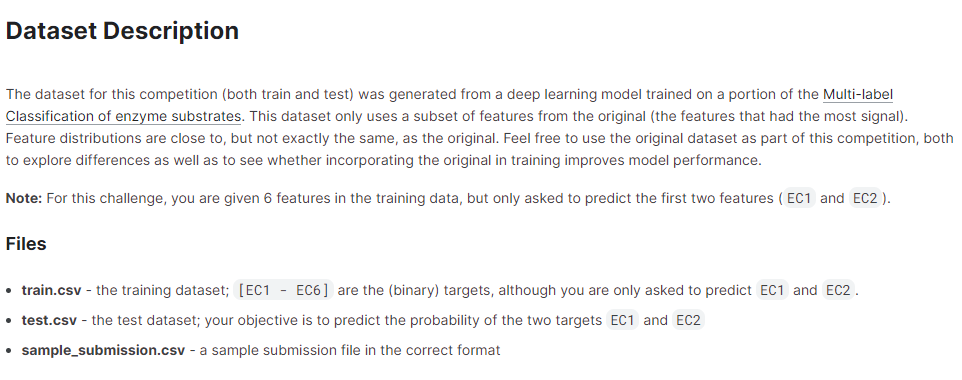

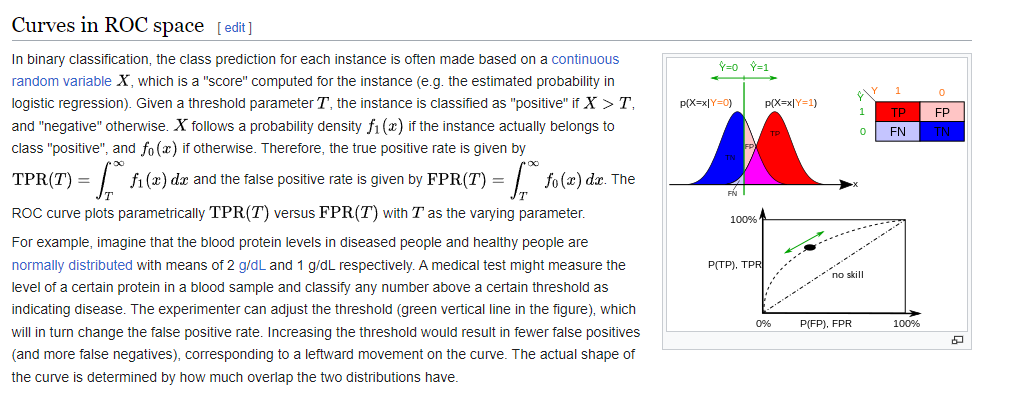

<div style="color:blue;
           display:fill;
           border-radius:5px;
           background-color:#1e07eb;
           font-size:110%;
           font-family:sans-serif;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
DEPENDENT PACAKGES FOR MODELLING
</p>
</div>

In [51]:
%%capture
!pip install ydata-profiling

In [52]:
%%capture
!pip install torchsampler

In [53]:
%%capture
!pip install torchmetrics

In [54]:
%%capture
!pip install ray

<div style="color:blue;
           display:fill;
           border-radius:5px;
           background-color:#1e07eb;
           font-size:110%;
           font-family:sans-serif;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
IMPORTING NECESSARY LIBRARIES 
</p>
</div>

In [55]:

import random
import numpy as np 
import pandas as pd 
import os
import datetime
import seaborn as sns
from tqdm.notebook import tqdm
from ydata_profiling import ProfileReport
from collections import Counter

from imblearn.over_sampling import SMOTE,SMOTEN
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve

from torchsampler import ImbalancedDatasetSampler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from torch.nn import functional as F
from torchmetrics import ROC
from torchmetrics.classification import BinaryAccuracy,BinaryROC


import ray
from ray import tune
from ray.air import session
from ray.air.checkpoint import Checkpoint
from ray.tune.schedulers import ASHAScheduler


import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')
import itertools

<div style="color:blue;
           display:fill;
           border-radius:5px;
           background-color:#1e07eb;
           font-size:110%;
           font-family:sans-serif;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
FILE AVAILABLE IN HOME DIRECTORY
</p>
</div>

In [56]:
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s3e18/sample_submission.csv
/kaggle/input/playground-series-s3e18/train.csv
/kaggle/input/playground-series-s3e18/test.csv


<div style="color:blue;
           display:fill;
           border-radius:5px;
           background-color:#1e07eb;
           font-size:110%;
           font-family:sans-serif;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
DATA ACQUISITION
</p>
</div>

In [57]:
class Datapreparation(object):
    
    def __init__(self,root_path):
        self.root_path = root_path
        
    def get_dataframe(self,filename):
        return pd.read_csv(os.path.join(self.root_path,filename))
    
    def summary(self,text, df):
        summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
        summary['null'] = df.isnull().sum()
        summary['unique'] = df.nunique()
        summary['min'] = df.min()
        summary['median'] = df.median()
        summary['max'] = df.max()
        summary['mean'] = df.mean()
        summary['std'] = df.std()
        summary['duplicate'] = df.duplicated().sum()
        return summary
    
    
    def random_split_data(self,X,y):
        return train_test_split(X, y,test_size=0.20,random_state=42)

 
    def standardization_data(self,X_data):
        scaler = StandardScaler()
        std_X_data = scaler.fit_transform(X_data)
        return std_X_data
    

    
data = Datapreparation('/kaggle/input/playground-series-s3e18')
train=data.get_dataframe('train.csv')

<div style="color:blue;
           display:fill;
           border-radius:5px;
           background-color:#1e07eb;
           font-size:110%;
           font-family:sans-serif;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
TRAIN DATA SUMMARY
</p>
</div>

In [58]:
data.summary('train',train)

,dtypes,null,unique,min,median,max,mean,std,duplicate
id,int64,0,14838,0.000000,7418.500000,14837.000000,7418.500000,4283.505982,0
BertzCT,float64,0,2368,0.000000,290.987941,4069.959780,515.153604,542.456370,0
Chi1,float64,0,1259,0.000000,6.485270,69.551167,9.135189,6.819989,0
Chi1n,float64,0,3157,0.000000,4.052701,50.174588,5.854307,4.647064,0
Chi1v,float64,0,3306,0.000000,4.392859,53.431954,6.738497,5.866444,0
Chi2n,float64,0,3634,0.000000,2.970427,32.195368,4.432570,3.760516,0
Chi2v,float64,0,3725,0.000000,3.242775,34.579313,5.253221,4.925065,0
Chi3v,float64,0,3448,0.000000,1.948613,22.880836,3.418749,3.436208,0
Chi4n,float64,0,2930,0.000000,1.073261,16.072810,1.773472,1.865898,0
EState_VSA1,float64,0,719,0.000000,17.353601,363.705954,29.202823,31.728679,0


<div style="color:blue;
           display:fill;
           border-radius:5px;
           background-color:#1e07eb;
           font-size:110%;
           font-family:sans-serif;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
TRAIN DATA PROFILING USING PROFILEREPORT METHOD
</p>
</div>

In [59]:
#profile = ProfileReport(train, title="Train Data Profiling Report")
#profile

<div style="color:blue;
           display:fill;
           border-radius:5px;
           background-color:#1e07eb;
           font-size:110%;
           font-family:sans-serif;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
SETTING UP FEATURES AND LABELS
</p>
</div>

In [60]:
y1 = train['EC1']
y2 = train['EC2']
train.drop(columns=['id','EC1','EC2','EC3','EC4','EC5','EC6'],axis=1,inplace=True)
X = train.copy()


<div style="color:blue;
           display:fill;
           border-radius:5px;
           background-color:#1e07eb;
           font-size:110%;
           font-family:sans-serif;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
SPLITTING THE TRAIN DATA
</p>
</div>

In [61]:
X_train,X_val,y1_train,y1_val = data.random_split_data(X,y1)
print('Data splits for EC1 \n',X_train.shape,X_val.shape,y1_train.shape,y1_val.shape)

Data splits for EC1 
 (11870, 31) (2968, 31) (11870,) (2968,)


In [62]:
X_train,X_val,y2_train,y2_val = data.random_split_data(X,y2)
print('Data splits for EC2 \n',X_train.shape,X_val.shape,y2_train.shape,y2_val.shape)

Data splits for EC2 
 (11870, 31) (2968, 31) (11870,) (2968,)


<div style="color:blue;
           display:fill;
           border-radius:5px;
           background-color:#1e07eb;
           font-size:110%;
           font-family:sans-serif;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
NORMALIZE TRAIN DATA
</p>
</div>

In [63]:
std_X_train = data.standardization_data(X_train)
std_X_val = data.standardization_data(X_val)
print(std_X_train[0],std_X_val[0])

[-0.6460012  -0.49660398 -0.53250602 -0.57261284 -0.5904852  -0.61753263
 -0.59673579 -0.62771573 -0.91411097  0.56344636 -0.56889535 -0.07305243
  0.81469479  1.50215144  0.0217275  -0.57591696 -0.08736038 -0.39329628
  1.34611003 -0.72802128 -0.78622974 -0.51646882  0.1563295   0.31295018
 -0.61487415 -0.5171512  -0.91283104 -0.93428166 -0.94969081 -0.68328343
 -0.68460195] [-0.73157789 -0.89416128 -0.71611727 -0.71782103 -0.74457679 -0.73521665
 -0.8362178  -0.84437652 -0.385045   -0.76779355 -0.74586676  0.06227215
  0.02884275  0.07397899  0.41849986 -0.75437549 -0.10510849 -0.80384358
  0.35858918 -0.61099998 -0.3717161  -0.33573224 -0.47165217 -0.56987761
 -0.62586121 -0.22583258 -0.54067893 -0.28699515 -0.54836477  0.78492852
  0.78337988]


<div style="color:blue;
           display:fill;
           border-radius:5px;
           background-color:#1e07eb;
           font-size:110%;
           font-family:sans-serif;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
TENSOR OPERATIONS
</p>
</div>

In [64]:
class Tensoroperations():
    
    def __init__(self):
        super(Tensoroperations,self).__init__()
    
    def convert_to_tensor(self,X,y=None):
        X_tensor =  torch.from_numpy(X).float()   
        y_tensor = torch.from_numpy(y).float() 
        return X_tensor,y_tensor
        
    def convert_to_test_tensor(self,X):
        X_tensor =  torch.from_numpy(X).float()
        return X_tensor
    
    def get_dataloaders(self,train_dataset,val_dataset):
        train_loaders = DataLoader(train_dataset,batch_size=32,shuffle=True)
        val_loaders = DataLoader(val_dataset,batch_size=32)
        return train_loaders,val_loaders
    
    def get_test_dataloaders(self,test_dataset,X_test):
        test_loaders = DataLoader(test_dataset,batch_size=X_test.shape[0])
        return test_loaders
        
        
    
tenops = Tensoroperations()

<div style="color:blue;
           display:fill;
           border-radius:5px;
           background-color:#1e07eb;
           font-size:110%;
           font-family:sans-serif;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
TRAIN CUSTOM DATASET
</p>
</div>

In [65]:
class CustomDataset(Dataset):
    
    def __init__(self,X_data,y_data=None,is_train=True):
        super().__init__()
        if is_train:
            self.X_data = X_data
            self.y_data = y_data
        else:
            self.X_data=X_train
            
    def __getitem__(self,index):
        return (self.X_data[index],self.y_data[index])
    
    def __len__(self):
        return len(self.X_data)

In [66]:
X_tensor_train,y1_tensor_train = tenops.convert_to_tensor(std_X_train,y1_train.values)
X_tensor_val,y1_tensor_val = tenops.convert_to_tensor(std_X_val,y1_val.values)
print('The training tensor for EC1\n',X_tensor_train,y1_tensor_train)
print('The validation tensor for EC1\n',X_tensor_val,y1_tensor_val)

The training tensor for EC1
 tensor([[-0.6460, -0.4966, -0.5325,  ..., -0.9497, -0.6833, -0.6846],
        [-0.7818, -0.9513, -0.8922,  ..., -1.0127,  0.8178,  0.8161],
        [ 2.1245,  1.5223,  1.7448,  ...,  2.0297, -0.6833, -0.6846],
        ...,
        [-0.2776,  0.0232, -0.3406,  ..., -0.6133, -0.6833, -0.6846],
        [-0.7166, -0.6467, -0.5530,  ..., -0.6577, -0.6833, -0.6846],
        [-0.8225, -0.8068, -0.8795,  ..., -0.8180, -0.6833, -0.6846]]) tensor([1., 1., 1.,  ..., 0., 0., 1.])
The validation tensor for EC1
 tensor([[-0.7316, -0.8942, -0.7161,  ..., -0.5484,  0.7849,  0.7834],
        [-0.2605,  0.2136,  0.2536,  ..., -0.2027, -0.6970, -0.6985],
        [-0.4432, -1.0872, -1.1129,  ..., -0.1914,  2.2669,  2.2653],
        ...,
        [-0.6615, -0.6798, -0.6762,  ..., -0.3160,  0.7849,  0.7834],
        [ 0.7218,  0.9378,  0.8351,  ...,  0.2456, -0.6970, -0.6985],
        [-0.8259, -0.8942, -0.8957,  ..., -0.9963, -0.6970, -0.6985]]) tensor([1., 0., 1.,  ..., 1., 0.,

In [67]:
X_tensor_train,y2_tensor_train = tenops.convert_to_tensor(std_X_train,y2_train.values)
X_tensor_val,y2_tensor_val = tenops.convert_to_tensor(std_X_val,y2_val.values)
print('The training tensor EC2\n',X_tensor_train,y2_tensor_train)
print('The validation tensor Ec2\n',X_tensor_val,y2_tensor_val)

The training tensor EC2
 tensor([[-0.6460, -0.4966, -0.5325,  ..., -0.9497, -0.6833, -0.6846],
        [-0.7818, -0.9513, -0.8922,  ..., -1.0127,  0.8178,  0.8161],
        [ 2.1245,  1.5223,  1.7448,  ...,  2.0297, -0.6833, -0.6846],
        ...,
        [-0.2776,  0.0232, -0.3406,  ..., -0.6133, -0.6833, -0.6846],
        [-0.7166, -0.6467, -0.5530,  ..., -0.6577, -0.6833, -0.6846],
        [-0.8225, -0.8068, -0.8795,  ..., -0.8180, -0.6833, -0.6846]]) tensor([1., 1., 0.,  ..., 1., 1., 1.])
The validation tensor Ec2
 tensor([[-0.7316, -0.8942, -0.7161,  ..., -0.5484,  0.7849,  0.7834],
        [-0.2605,  0.2136,  0.2536,  ..., -0.2027, -0.6970, -0.6985],
        [-0.4432, -1.0872, -1.1129,  ..., -0.1914,  2.2669,  2.2653],
        ...,
        [-0.6615, -0.6798, -0.6762,  ..., -0.3160,  0.7849,  0.7834],
        [ 0.7218,  0.9378,  0.8351,  ...,  0.2456, -0.6970, -0.6985],
        [-0.8259, -0.8942, -0.8957,  ..., -0.9963, -0.6970, -0.6985]]) tensor([1., 1., 1.,  ..., 1., 1., 1.])


In [68]:
false_pos,true_pos = [],[]

<div style="color:blue;
           display:fill;
           border-radius:5px;
           background-color:#1e07eb;
           font-size:110%;
           font-family:sans-serif;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
TRAINING AND VALIDATION STEPS WITH BINARY ACCURACY
</p>
</div>

In [69]:
class EnzymeClassificationBase(torch.nn.Module):
    
    def _accuracy(self,outputs, labels):
        #return torch.tensor(outputs.round() == labels).float().mean()
        metric = BinaryAccuracy()
        return metric(outputs, labels.unsqueeze(1))
    
    
    def training_step(self,batch):
        features,labels = batch
        out = self(features)
        loss = F.binary_cross_entropy(out,labels.unsqueeze(1))
        return loss
    
    def validation_step(self, batch):
        features, labels = batch 
        out = self(features)                    # Generate predictions
        loss = F.binary_cross_entropy(out, labels.unsqueeze(1))   # Calculate loss
        acc = self._accuracy(out, labels)           # Calculate accuracy
        self._get_roc(out, labels)
        return {'Validation_loss': loss.detach(), 'Validation_acc': acc}
    
    def _get_roc(self,output,labels):
        roc = ROC(task="binary")
        fpr, tpr, thresholds = roc(output, (labels.long()).unsqueeze(1))
        false_pos.append(fpr)
        true_pos.append(tpr)
        
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['Validation_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['Validation_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'Validation_loss': epoch_loss.item(), 'Validation_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        if epoch%10 == 0:
            print("Epoch [{}], Train_loss: {:.4f}, Validation_loss: {:.4f}, Validation_acc: {:.4f}".format(
                epoch, result['Train_loss'], result['Validation_loss'], result['Validation_acc']))

<div style="color:blue;
           display:fill;
           border-radius:5px;
           background-color:#1e07eb;
           font-size:110%;
           font-family:sans-serif;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
THE MODEL
</p>
</div>

In [70]:
n_input_dim = X_train.shape[1]
n_output =  1   # Number of output nodes = for binary classifier

class MultiClassificationNN(EnzymeClassificationBase):
    
    def __init__(self):
        super(MultiClassificationNN, self).__init__()
        
        self.network = torch.nn.Sequential(
            torch.nn.Linear(n_input_dim,32),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(32,16),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(16,8),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(8,n_output),
            torch.nn.Sigmoid()
        )
    
    def forward(self, xb):
        return self.network(xb)


model_EC1 = MultiClassificationNN()
model_EC2 = MultiClassificationNN()

In [71]:
print(model_EC1)

MultiClassificationNN(
  (network): Sequential(
    (0): Linear(in_features=31, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=8, out_features=4, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=4, out_features=1, bias=True)
    (9): Sigmoid()
  )
)


In [72]:
print(model_EC2)

MultiClassificationNN(
  (network): Sequential(
    (0): Linear(in_features=31, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=8, out_features=4, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=4, out_features=1, bias=True)
    (9): Sigmoid()
  )
)


<div style="color:blue;
           display:fill;
           border-radius:5px;
           background-color:#1e07eb;
           font-size:110%;
           font-family:sans-serif;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
PREPARING THE TRAIN AND VALIDATION DATA LOADERS
</p>
</div>

In [73]:
train1_dataset = CustomDataset(X_tensor_train,y1_tensor_train)
val1_dataset = CustomDataset(X_tensor_val,y1_tensor_val)

train2_dataset = CustomDataset(X_tensor_train,y2_tensor_train)
val2_dataset = CustomDataset(X_tensor_val,y2_tensor_val)

In [74]:
train_dataloader = DataLoader(train1_dataset,64,shuffle=True)
val_dataloader = DataLoader(val1_dataset,64)

In [75]:
train_dataloader2 = DataLoader(train2_dataset,64,shuffle=True)
val_dataloader2 = DataLoader(val2_dataset,64)

In [76]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

<div style="color:blue;
           display:fill;
           border-radius:5px;
           background-color:#1e07eb;
           font-size:110%;
           font-family:sans-serif;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
CLASS TARINER
</p>
</div>

In [77]:
class Trainer:
    
    @torch.no_grad()
    def _evaluate(self,model, val_loader):
        model.eval()
        outputs = [model.validation_step(batch) for batch in val_loader]
        return model.validation_epoch_end(outputs)

  
    def fit(self,epochs, lr, model, train_loader, val_loader, opt_func):
    
        history = []
        optimizer = opt_func(model.parameters(),lr,weight_decay=2e-5)
        for epoch in tqdm(range(epochs)):
        
            model.train()
            train_losses = []
            for batch in train_loader:
                loss = model.training_step(batch)
                train_losses.append(loss)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            
            result = self._evaluate(model, val_loader)
            result['Train_loss'] = torch.stack(train_losses).mean().item()
            model.epoch_end(epoch, result)
            history.append(result)
    
        return history

<div style="color:blue;
           display:fill;
           border-radius:5px;
           background-color:#1e07eb;
           font-size:110%;
           font-family:sans-serif;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
HYPER PARAMETERS
</p>
</div>

In [78]:
num_epochs=100
lr=1e-4
opt_func= torch.optim.Adam

<div style="color:blue;
           display:fill;
           border-radius:5px;
           background-color:#1e07eb;
           font-size:110%;
           font-family:sans-serif;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
EC1 TRAINING
</p>
</div>

In [79]:
tariner=Trainer()
history_EC1 = tariner.fit(num_epochs, lr, model_EC1, train_dataloader, val_dataloader, opt_func)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [0], Train_loss: 0.6808, Validation_loss: 0.6754, Validation_acc: 0.6722
Epoch [10], Train_loss: 0.5862, Validation_loss: 0.5786, Validation_acc: 0.6888
Epoch [20], Train_loss: 0.5817, Validation_loss: 0.5759, Validation_acc: 0.7017
Epoch [30], Train_loss: 0.5800, Validation_loss: 0.5755, Validation_acc: 0.7033
Epoch [40], Train_loss: 0.5787, Validation_loss: 0.5746, Validation_acc: 0.7008
Epoch [50], Train_loss: 0.5773, Validation_loss: 0.5741, Validation_acc: 0.7008
Epoch [60], Train_loss: 0.5763, Validation_loss: 0.5741, Validation_acc: 0.7015
Epoch [70], Train_loss: 0.5755, Validation_loss: 0.5731, Validation_acc: 0.6997
Epoch [80], Train_loss: 0.5746, Validation_loss: 0.5733, Validation_acc: 0.6997
Epoch [90], Train_loss: 0.5740, Validation_loss: 0.5727, Validation_acc: 0.7004


<div style="color:blue;
           display:fill;
           border-radius:5px;
           background-color:#1e07eb;
           font-size:110%;
           font-family:sans-serif;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
EC1 ACCURACY PLOT
</p>
</div>

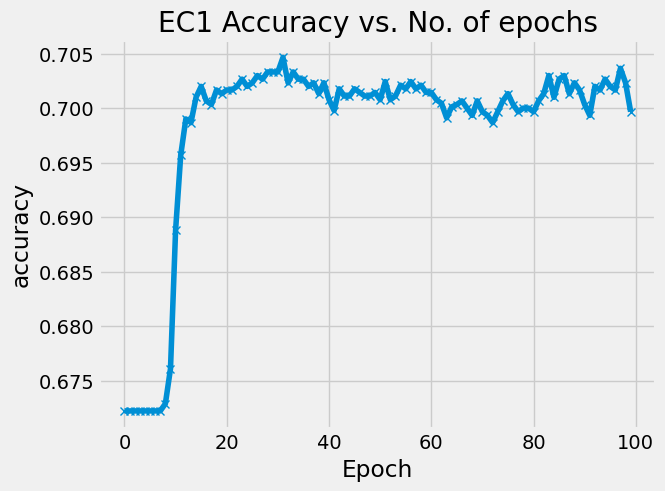

In [80]:
def plot_accuracies(history_EC1):
    """ Plot the history of accuracies"""
    accuracies = [x['Validation_acc'] for x in history_EC1]
    plt.plot(accuracies, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.title('EC1 Accuracy vs. No. of epochs');
    
plot_accuracies(history_EC1)

<div style="color:blue;
           display:fill;
           border-radius:5px;
           background-color:#1e07eb;
           font-size:110%;
           font-family:sans-serif;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
EC1 LOSS VS EPOCHS
</p>
</div>

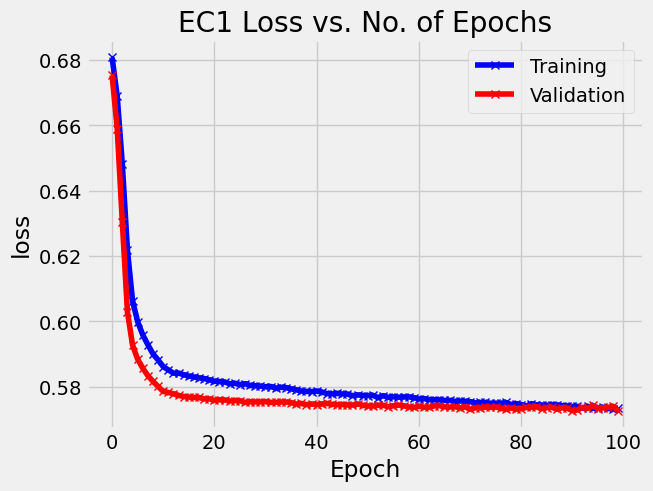

In [81]:
def plot_losses(history_EC1):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('Train_loss') for x in history_EC1]
    val_losses = [x['Validation_loss'] for x in history_EC1]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('EC1 Loss vs. No. of Epochs')

plot_losses(history_EC1)

<div style="color:blue;
           display:fill;
           border-radius:5px;
           background-color:#1e07eb;
           font-size:110%;
           font-family:sans-serif;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
AUC ROC EC1
</p>
</div>

In [82]:
fpr,tpr =[],[]
for i in range(len(false_pos)):
        fpr.append(np.mean(false_pos[i].tolist()))

for j in range(len(true_pos)):
        tpr.append(np.mean(false_pos[j].tolist()))


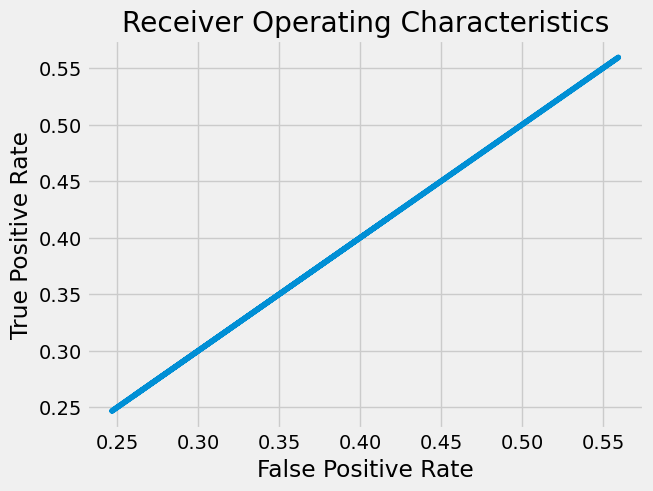

In [83]:
with torch.no_grad():
    plt.plot(fpr,tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()



<div style="color:blue;
           display:fill;
           border-radius:5px;
           background-color:#1e07eb;
           font-size:110%;
           font-family:sans-serif;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
EC2 TRANING
</p>
</div>

In [84]:
history_EC2 = tariner.fit(num_epochs, lr, model_EC2, train_dataloader2, val_dataloader2, opt_func)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [0], Train_loss: 0.6116, Validation_loss: 0.5965, Validation_acc: 0.8090
Epoch [10], Train_loss: 0.5049, Validation_loss: 0.4892, Validation_acc: 0.8090
Epoch [20], Train_loss: 0.4994, Validation_loss: 0.4831, Validation_acc: 0.8090
Epoch [30], Train_loss: 0.4980, Validation_loss: 0.4821, Validation_acc: 0.8090
Epoch [40], Train_loss: 0.4969, Validation_loss: 0.4814, Validation_acc: 0.8090
Epoch [50], Train_loss: 0.4960, Validation_loss: 0.4813, Validation_acc: 0.8090
Epoch [60], Train_loss: 0.4958, Validation_loss: 0.4807, Validation_acc: 0.8090
Epoch [70], Train_loss: 0.4950, Validation_loss: 0.4806, Validation_acc: 0.8090
Epoch [80], Train_loss: 0.4943, Validation_loss: 0.4805, Validation_acc: 0.8090
Epoch [90], Train_loss: 0.4942, Validation_loss: 0.4804, Validation_acc: 0.8090


<div style="color:blue;
           display:fill;
           border-radius:5px;
           background-color:#1e07eb;
           font-size:110%;
           font-family:sans-serif;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
EC2 ACCURACY
</p>
</div>

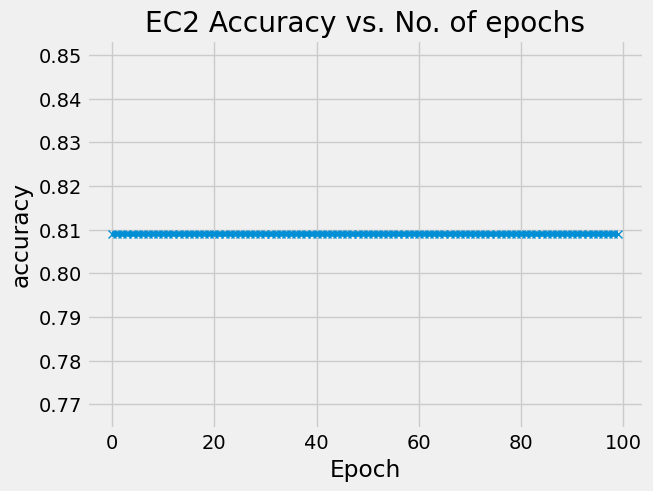

In [85]:
def plot_accuracies(history_EC2):
    """ Plot the history of accuracies"""
    accuracies = [x['Validation_acc'] for x in history_EC2]
    plt.plot(accuracies, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.title('EC2 Accuracy vs. No. of epochs');
    
plot_accuracies(history_EC2)

<div style="color:blue;
           display:fill;
           border-radius:5px;
           background-color:#1e07eb;
           font-size:110%;
           font-family:sans-serif;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
EC2 LOSS VS EPOCHS
</p>
</div>

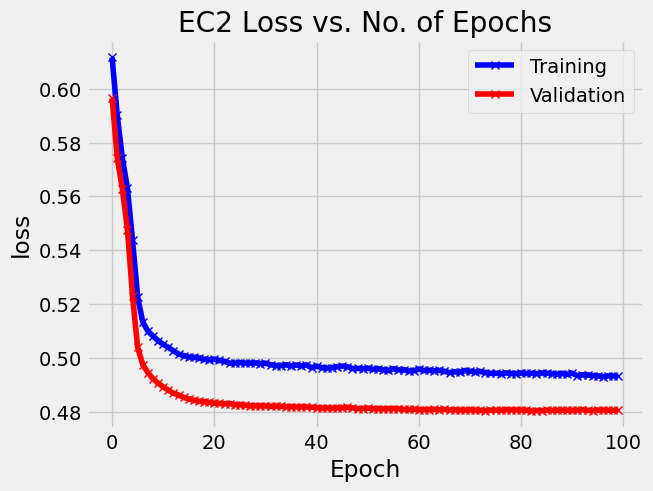

In [86]:
def plot_losses(history_EC2):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('Train_loss') for x in history_EC2]
    val_losses = [x['Validation_loss'] for x in history_EC2]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('EC2 Loss vs. No. of Epochs')

plot_losses(history_EC2)

<div style="color:blue;
           display:fill;
           border-radius:5px;
           background-color:#1e07eb;
           font-size:110%;
           font-family:sans-serif;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
AUC ROC EC2
</p>
</div>

In [87]:
fpr,tpr =[],[]
for i in range(len(false_pos)):
        fpr.append(np.mean(false_pos[i].tolist()))

for j in range(len(true_pos)):
        tpr.append(np.mean(false_pos[j].tolist()))


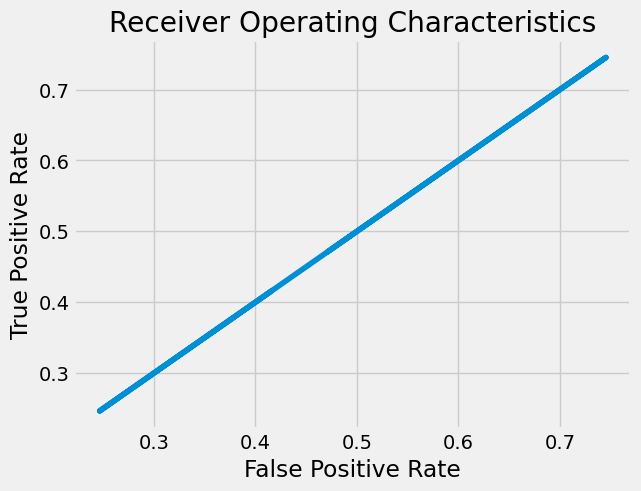

In [88]:

with torch.no_grad():
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()


<div style="color:blue;
           display:fill;
           border-radius:5px;
           background-color:#1e07eb;
           font-size:110%;
           font-family:sans-serif;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
TEST DATA ACQISITION
</p>
</div>

In [89]:
test=data.get_dataframe('test.csv')

<div style="color:blue;
           display:fill;
           border-radius:5px;
           background-color:#1e07eb;
           font-size:110%;
           font-family:sans-serif;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
TEST DATA SUMMARY
</p>
</div>

In [90]:
data.summary('test',test)

,dtypes,null,unique,min,median,max,mean,std,duplicate
id,int64,0,9893,14838.000000,19784.000000,24730.000000,19784.000000,2856.007440,0
BertzCT,float64,0,1811,0.000000,289.901774,3919.541449,516.411916,544.327795,0
Chi1,float64,0,1047,0.000000,6.447265,53.876516,9.106998,6.754583,0
Chi1n,float64,0,2473,0.000000,4.009996,43.283925,5.848047,4.641662,0
Chi1v,float64,0,2604,0.000000,4.337841,53.990574,6.733659,5.863886,0
Chi2n,float64,0,2806,0.000000,2.930013,36.368883,4.428979,3.770031,0
Chi2v,float64,0,2858,0.000000,3.168052,44.726398,5.247994,4.939702,0
Chi3v,float64,0,2644,0.000000,1.923982,26.736931,3.401083,3.431766,0
Chi4n,float64,0,2249,0.000000,1.058931,15.620667,1.750078,1.837159,0
EState_VSA1,float64,0,582,0.000000,17.282269,363.705954,28.956335,31.470865,0


<div style="color:blue;
           display:fill;
           border-radius:5px;
           background-color:#1e07eb;
           font-size:110%;
           font-family:sans-serif;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
TEST DATA PROFILING REPORT
</p>
</div>

In [91]:
#profile_test = ProfileReport(test, title="Test Data Profiling Report")
#profile_test

<div style="color:blue;
           display:fill;
           border-radius:5px;
           background-color:#1e07eb;
           font-size:110%;
           font-family:sans-serif;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
TEST FEATURES
</p>
</div>

In [92]:
test_update = test.loc[:, test.columns != 'id']
std_X_test = data.standardization_data(test_update)
std_X_test[0]

array([-0.31559702, -0.26996293, -0.29604713, -0.15326805, -0.26969872,
       -0.12075512, -0.38015134, -0.34492222,  0.65150045, -0.76517602,
       -0.39138395,  0.28708683,  0.17578552,  0.00940321,  1.04728953,
       -0.38804569, -0.05445579, -0.19503344, -1.27986015, -0.2075983 ,
        0.52346399, -0.13900777, -0.46065274, -0.56072839, -0.62994368,
        0.60218712, -0.19027332, -0.59956194, -0.0718545 ,  0.79849656,
        0.7956248 ])

<div style="color:blue;
           display:fill;
           border-radius:5px;
           background-color:#1e07eb;
           font-size:110%;
           font-family:sans-serif;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
NORMALIZE TEST DATA
</p>
</div>

In [93]:
X_tensor_test = tenops.convert_to_test_tensor(std_X_test)
X_tensor_test[0]

tensor([-0.3156, -0.2700, -0.2960, -0.1533, -0.2697, -0.1208, -0.3802, -0.3449,
         0.6515, -0.7652, -0.3914,  0.2871,  0.1758,  0.0094,  1.0473, -0.3880,
        -0.0545, -0.1950, -1.2799, -0.2076,  0.5235, -0.1390, -0.4607, -0.5607,
        -0.6299,  0.6022, -0.1903, -0.5996, -0.0719,  0.7985,  0.7956])

<div style="color:blue;
           display:fill;
           border-radius:5px;
           background-color:#1e07eb;
           font-size:110%;
           font-family:sans-serif;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
CUSTOM DATASET FOR TEST
</p>
</div>

In [94]:
class CustomDataTest(Dataset):
    def __init__(self, X_data):
        self.X_data = X_data

        
    def __getitem__(self, index):
            return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [95]:
test_dataset = CustomDataTest(X_tensor_test)
test_dataloader = DataLoader(test_dataset,64)

<div style="color:blue;
           display:fill;
           border-radius:5px;
           background-color:#1e07eb;
           font-size:110%;
           font-family:sans-serif;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
MODEL EVALUATION FROM TEST DATA FOR EC1 AND EC2
</p>
</div>

In [96]:
class Evaluate:
        
    def eval_test_data(self,model,test_data_dl):
        age_target = []
        model.eval()
        with torch.no_grad():
            for X_batch_test in test_data_dl:
                X_batch_test = X_batch_test.to(device)
                y_test_pred = model(X_batch_test)
                y_pred_tag = torch.sigmoid(y_test_pred)
                age_target.append(y_pred_tag.cpu())
        return [a.squeeze().tolist() for a in age_target]
    
    
eva = Evaluate()

<div style="color:blue;
           display:fill;
           border-radius:5px;
           background-color:#1e07eb;
           font-size:110%;
           font-family:sans-serif;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
FLATTENING THE EC1 AND EC2 TENSORS
</p>
</div>

In [97]:
from collections.abc import Iterable
def flatten(lis):
    for item in lis:
        if isinstance(item, Iterable) and not isinstance(item, str):
            for x in flatten(item):
                yield x
        else:        
            yield item
            
ec1 = eva.eval_test_data(model_EC1,test_dataloader)
ec2 = eva.eval_test_data(model_EC2,test_dataloader)

<div style="color:blue;
           display:fill;
           border-radius:5px;
           background-color:#1e07eb;
           font-size:110%;
           font-family:sans-serif;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
THE SUBMISSIONS
</p>
</div>

In [98]:
class Submit:
    
    def submit_predictions(self):        
        df_submit = pd.DataFrame(data={'id': test['id'],'EC1':  list(flatten(ec1)),'EC2':list(flatten(ec2))})
        df_submit.to_csv('submission.csv',index=False)
        print('Submission Completed!!')
        return df_submit
        
        
submit = Submit()
df_submit=submit.submit_predictions()

Submission Completed!!


<div style="color:blue;
           display:fill;
           border-radius:5px;
           background-color:#1e07eb;
           font-size:110%;
           font-family:sans-serif;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
SUMISSION DATAFRAME
</p>
</div>

In [99]:
df_submit

,id,EC1,EC2
0,14838,0.606922,0.683604
1,14839,0.694905,0.698749
2,14840,0.687027,0.679046
3,14841,0.674560,0.700421
4,14842,0.685948,0.686628
...,...,...,...
9888,24726,0.655815,0.684250
9889,24727,0.697925,0.705416
9890,24728,0.616478,0.692654
9891,24729,0.604763,0.701498
